In [5]:
pip install pandas
pip install scikit-learn
pip install matplotlib
pip install xgboost
pip install yellowbrick
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the 'C:\Users\dhideo\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [2]:
#Pandas para manipulação dos dados
import pandas as pd
#Para input de valores nulos
import numpy as np
#Para leitura dos dados
import json as js
#Método para imputação dos dados, seja categórico seja numérico
from sklearn.impute import SimpleImputer
#Para plotar
import matplotlib.pyplot as plt
import seaborn as sns
#Para separação dos dados entre treino e validação
from sklearn.model_selection import train_test_split
#Para criação do modelo RandomForest
from sklearn.ensemble import RandomForestRegressor
#Para medir acurácia do modelo
from sklearn.metrics import mean_absolute_error
#Para medição de previsões
from sklearn import metrics
#Para criação do modelo de árvore de decisão
from sklearn.tree import DecisionTreeRegressor
#Método para encodar dados categóricos
from sklearn.preprocessing import OneHotEncoder

In [3]:
#Limitar quantidade de linhas impressas
pd.set_option('max_rows', 10)

#Não tenho tantas colunas assim, então prefiro ver todas
pd.set_option('display.max_columns', None)

#Printar de forma mais legível
pd.options.display.float_format = '${:,.2f}'.format

# PREPROCESS TRAIN DATASET

In [7]:
df = pd.read_json("C:/Users/dhideo/Documents/Dataset do projeto Grupo OLX/source-4-ds-train.json",lines=True)

#TRATAMENTO DOS TIPOS DE LOCALCAO E AJUSTE DA VARIAVEL ALVO
df['sale'] = 0

#Atualizando para o tipo de venda, caso 1 é venda caso 0 negativo. Como a maior parte do meu dataset é de vendas, achei produtivo saber quais são vendas e quais não são
for i in range(df.shape[0]):
        if df.iloc[i]['pricingInfos']['businessType'] == 'SALE':
            df.at[i,'sale'] = 1

df['period'] = 'NA'

#Atualizando tipo de periodo (Monthly, Daily, NA, Yearly), dessa forma conseguirei destrinchar os precos de cada tipo de imovel
for i in range(df.shape[0]):
        if df.iloc[i]['pricingInfos']['businessType'] == 'RENTAL':
            if df.iloc[i]['pricingInfos']['period'] != 'MONTHLY':
                df.at[i, 'period'] = df.iloc[i]['pricingInfos']['period']
            else:
                df.at[i, 'period'] = 'MONTHLY'
                
df['price'] = 0

#Atualizando o campo preço dos diferentes tipos de locacao
for index, row in df[df['period'] == 'NA'].iterrows():
    df.loc[index, 'price'] = row['pricingInfos']['price']

for index, row in df[df['period'] == 'MONTHLY'].iterrows():
    df.loc[index, 'price'] = row['pricingInfos']['rentalTotalPrice']

for index, row in df[df['period'] == 'DAILY'].iterrows():
    df.loc[index, 'price'] = row['pricingInfos']['price']

for index, row in df[df['period'] == 'YEARLY'].iterrows():
    df.loc[index, 'price'] = row['pricingInfos']['price']

df = df.replace(r'NA', np.nan, regex=True)

#Dropando a coluna pricingInfos e price uma vez que já tratei a variável target
df.drop(['pricingInfos'], axis = 1, inplace=True)
y = df.price

df.drop(['price'], axis = 1, inplace=True)

#Para testes e facilidade, irei remover a coluna UpdateAt pois por se tratar de uma data de atualização acredito não ter influência
df.drop(['updatedAt'], axis=1, inplace=True)

#Analisando o dataframe acima a coluna ID parece ter pouca ou nenhuma relevância, já que claramente se trata de uma coluna identificadora, logo irei remover
df.drop('id', axis=1, inplace=True)

#Mesma coisa com o publisherID
df.drop('publisherId', axis=1, inplace=True)

#Coluna imagem não fornece informação relevante de primeira
df.drop('images', axis=1, inplace=True)

#Removendo campo que informa data criação do anúncio
df.drop('createdAt', axis=1, inplace=True)


#replace all values NA  
df = df.replace(r'^\s*$', np.nan, regex=True)


###########################################################################################################################################################################################################

#porém como dentro dessa única coluna possuo uma quantidade relevante de informações, irei primeiro separar num dataset a parte para uma exploração maior
ads = pd.DataFrame(df['address'])


#Criando os campos adicionais
ads['country'] = 'NA'
ads['zipCode'] = 'NA'
ads['city'] = 'NA'
ads['streetNumber'] = 'NA'
ads['zone'] = 'NA'
#ads['geoLocation'] = 'NA'
#ads['location'] = 'NA'
ads['street'] = 'NA'
ads['locationId'] = 'NA'
ads['district'] = 'NA'
ads['unitNumber'] = 'NA'
ads['state'] = 'NA'
ads['neighborhood'] = 'NA'

for index, row in ads.iterrows():
    ads.loc[index, 'country'] = row['address']['country']
    ads.loc[index, 'country'] = row['address']['country']
    ads.loc[index, 'zipCode'] = row['address']['zipCode']
    ads.loc[index, 'city'] = row['address']['city']
    ads.loc[index, 'streetNumber'] = row['address']['streetNumber']
    ads.loc[index, 'zone'] = row['address']['zone']
    #ads.loc[index, 'geoLocation'] = row['address']['geoLocation']
    #ads.loc[index, 'location'] = row['address']['location']
    ads.loc[index, 'street'] = row['address']['street']
    ads.loc[index, 'locationId'] = row['address']['locationId']
    ads.loc[index, 'district'] = row['address']['district']
    ads.loc[index, 'unitNumber'] = row['address']['unitNumber']
    ads.loc[index, 'state'] = row['address']['state']
    ads.loc[index, 'neighborhood'] = row['address']['neighborhood']
    

#após esse processo podemos se livrar da coluna address
ads.drop(['address'], axis = 1, inplace=True)

#Como sabemos que o dataset se trata de imóveis localizados no Brasil, iremos remover a coluna country
ads.drop(['country'], axis = 1, inplace=True)

#Percebe-se que a coluna unitnumber se trata de informações adicionais providas talvez pelo anunciante, logo irei desconsiderar essa coluna por não ser confiável e ter pouquíssimos registros preenchidos
ads.drop(['unitNumber'], axis=1, inplace = True)

#irei verificar o tamanho do vetor retornado pelo split, se este for igual a 6, então irá conter o valor que preciso na zona
ads['zone'] = ads['locationId'].map(lambda x: x.split('>')[4] if len(x.split('>')) == 6 else '')

#irei obter agora o conjunto com até quatro posições
ads[ads['zone'].isnull()]['zone'] = ads[ads['zone'].isnull()]['locationId'].map(lambda x: x.split('>')[3] if len(x.split('>')) == 4 else '')

#Como se trata de apenas 60 registros com zona nulo irei atualizar manualmente
for index, row in ads[ads['zone'].isnull()].iterrows():
    ads.loc[index, 'zone'] = row['locationId'].split('>')[3]

#replace all empty spaces to values NA  
ads = ads.replace(r'^\s*$', np.nan, regex=True)

#Como se trata de apenas 60 registros com zona nulo irei atualizar manualmente
for index, row in ads[ads['zone'].isnull()].iterrows():
    ads.loc[index, 'zone'] = row['locationId'].split('>')[3]

#Zonas inconsistentes
zonas_estranhas = ['Sao Paulo','Barrios','Vinhedo']

#Após verificar que existiam ainda 91 registros preenchidos porém em zonas desconhecidas, irei atualizar estes com as zonas que encontrar com base no dataset original
for index, row in ads.loc[ads['zone'].isin(zonas_estranhas)].iterrows():
    if ads[(ads['neighborhood'] == row['neighborhood']) & (ads['zone'].notnull())].shape[0] > 1:
        #print(ads[(ads['neighborhood'] == row['neighborhood']) & (ads['zone'].notnull())].iloc[0].zone)
        ads.loc[index, 'zone'] = ads[(ads['neighborhood'] == row['neighborhood']) & (ads['zone'].notnull())].iloc[0].zone

##
#Por mais que temos 30 registros com zona inconsistente, será feito um trabalho de imputação de dados, utilizando SimpleImputer, pois este quantitativo representa 0,02% do dataset
#ads['zone'].value_counts()

#Pegando informação do distrito na quinta posicao do campo locationId
ads['district'] = ads.locationId.map(lambda x: x.split('>')[5] if len(x.split('>')) == 6 else '')

#Apos obter todos os valores validos da coluna LocationID irei remover a mesma
ads.drop('locationId', axis= 1, inplace=True)

#Num primeiro momento irei remover a variável streetNumber pois de forma empírica acredito não ser relevante
ads.drop('streetNumber', axis= 1, inplace=True)

#Como se trata de apenas 3 registros com estado nulo, irei atualizar manualmente
for index, row in ads[ads.state.isnull()].iterrows():
    ads.loc[index, 'state'] = 'São Paulo'
    
#State contendo SP e deveria ser São Paulo
for index, row in ads[ads.state == 'SP'].iterrows():
    ads.loc[index, 'state'] = 'São Paulo'

#Tratando esses poucos registros para zona sul para testes
ads.loc[ads['zone'] == 'Sao Paulo', 'zone'] = 'Zona Sul'
ads.loc[ads['zone'] == 'Barrios', 'zone'] = 'Zona Sul'
    
#replace all values NA  
ads = ads.replace(r'^\s*$', np.nan, regex=True)


#Removendo o campo address uma vez que já obtive todos os valores
df.drop('address', axis= 1, inplace=True)

###########################################################################################################################################################################################################


df2 = df.copy()

#Atualizando o campo period para VENDA, pois todos que estão nulos são anuncios de vendas
df2.loc[df2['period'].isnull(), ['period']] = 'VENDA'

#Atualizando description onde é nulo para o valor do title
df2.loc[df2['description'].isnull(), ['description']] = df2.loc[df2['description'].isnull()].title

#Mesma coisa ao contrário para o campo title
df2.loc[df2['title'].isnull(), ['title']] = df2.loc[df2['title'].isnull()].description


#Tratando coluna usableAreas
imputer = SimpleImputer(missing_values=np.nan,strategy='mean')
imputer = imputer.fit(df2[['usableAreas']])
result = imputer.transform(df2[['usableAreas']])
ex = pd.DataFrame(result).reset_index()
df2.usableAreas = ex[0].map(lambda x : int(x))

#Tratando coluna bedrooms
#imputer = SimpleImputer(missing_values=np.nan,strategy='mean')
imputer = imputer.fit(df2[['bedrooms']])
result = imputer.transform(df2[['bedrooms']])
ex = pd.DataFrame(result).reset_index()
df2.bedrooms = ex[0].map(lambda x : int(x))

#Tratando coluna bathrooms
#imputer = SimpleImputer(missing_values=np.nan,strategy='mean')
imputer = imputer.fit(df2[['bathrooms']])
result = imputer.transform(df2[['bathrooms']])
ex = pd.DataFrame(result).reset_index()
df2.bathrooms = ex[0].map(lambda x : int(x))

#Tratando coluna totalAreas
#imputer = SimpleImputer(missing_values=np.nan,strategy='mean')
imputer = imputer.fit(df2[['totalAreas']])
result = imputer.transform(df2[['totalAreas']])
ex = pd.DataFrame(result).reset_index()
df2.totalAreas = ex[0].map(lambda x : int(x))

#Tratando coluna suites
#imputer = SimpleImputer(missing_values=np.nan,strategy='mean')
imputer = imputer.fit(df2[['suites']])
result = imputer.transform(df2[['suites']])
ex = pd.DataFrame(result).reset_index()
df2.suites = ex[0].map(lambda x : int(x))

#Tratando coluna parkingSpaces
#imputer = SimpleImputer(missing_values=np.nan,strategy='mean')
imputer = imputer.fit(df2[['parkingSpaces']])
result = imputer.transform(df2[['parkingSpaces']])
ex = pd.DataFrame(result).reset_index()
df2.parkingSpaces = ex[0].map(lambda x : int(x))

df2.loc[df2.description.isnull(), 'description'] = 'vazio'
df2.loc[df2.title.isnull(), 'title'] = 'vazio'


ads2 = ads.copy()


#Tratando coluna zipCode
#imputer = SimpleImputer(missing_values=np.nan,strategy='mean')
imputer = imputer.fit(ads2[['zipCode']])
result = imputer.transform(ads2[['zipCode']])
ex = pd.DataFrame(result).reset_index()
ads2.zipCode = ex[0].map(lambda x : int(x))

#Mais para frente o ideal é fazer um trabalho preenchendo com base nas outras informações de rua, bairro, zona puxar a informação do ZipCODE !!!!!!!!!!!!!!!!!!

#Para district
second_imputer = SimpleImputer(strategy = 'most_frequent')
second_imputer = second_imputer.fit(ads2[['district']])
result = second_imputer.transform(ads2[['district']])
ads2.district = result

#Para neighborhood
second_imputer = SimpleImputer(strategy = 'most_frequent')
second_imputer = second_imputer.fit(ads2[['neighborhood']])
result = second_imputer.transform(ads2[['neighborhood']])
ads2.neighborhood = result

#Para street
second_imputer = SimpleImputer(strategy = 'most_frequent')
second_imputer = second_imputer.fit(ads2[['street']])
result = second_imputer.transform(ads2[['street']])
ads2.street = result



#Ao fim irei consolidar meu dataset
treino = pd.concat([df2, ads2], axis=1)

# PREPROCESS TEST DATASET

In [96]:
test = pd.read_json("C:/Users/dhideo/Documents/Dataset do projeto Grupo OLX/source-4-ds-test.json",lines=True)

#TRATAMENTO DOS TIPOS DE LOCALCAO E AJUSTE DA VARIAVEL ALVO
test['sale'] = 0

#Atualizando para o tipo de venda, caso 1 é venda caso 0 negativo. Como a maior parte do meu dataset é de vendas, achei produtivo saber quais são vendas e quais não são
for i in range(test.shape[0]):
        if test.iloc[i]['pricingInfos']['businessType'] == 'SALE':
            test.at[i,'sale'] = 1

test['period'] = 'NA'

#Atualizando tipo de periodo (Monthly, Daily, NA, Yearly), dessa forma conseguirei destrinchar os precos de cada tipo de imovel
for i in range(test.shape[0]):
        if test.iloc[i]['pricingInfos']['businessType'] == 'RENTAL':
            if test.iloc[i]['pricingInfos']['period'] != 'MONTHLY':
                test.at[i, 'period'] = test.iloc[i]['pricingInfos']['period']
            else:
                test.at[i, 'period'] = 'MONTHLY'
                

#Atualizando o campo preço dos diferentes tipos de locacao
for index, row in test[test['period'] == 'NA'].iterrows():
    test.loc[index, 'price'] = row['pricingInfos']['price']

for index, row in test[test['period'] == 'MONTHLY'].iterrows():
    test.loc[index, 'price'] = row['pricingInfos']['rentalTotalPrice']

for index, row in test[test['period'] == 'DAILY'].iterrows():
    test.loc[index, 'price'] = row['pricingInfos']['price']

for index, row in test[test['period'] == 'YEARLY'].iterrows():
    test.loc[index, 'price'] = row['pricingInfos']['price']

test = test.replace(r'NA', np.nan, regex=True)

#Dropando a coluna pricingInfos e price uma vez que já tratei a variável target
test.drop(['pricingInfos'], axis = 1, inplace=True)

#Para testes e facilidade, irei remover a coluna UpdateAt pois por se tratar de uma data de atualização acredito não ter influência
test.drop(['updatedAt'], axis=1, inplace=True)

#Analisando o dataframe acima a coluna ID parece ter pouca ou nenhuma relevância, já que claramente se trata de uma coluna identificadora, logo irei remover
test.drop('id', axis=1, inplace=True)

#Mesma coisa com o publisherID
test.drop('publisherId', axis=1, inplace=True)

#Coluna imagem não fornece informação relevante de primeira
test.drop('images', axis=1, inplace=True)

#Removendo coluna target
test.drop('price', axis=1, inplace=True)

test.replace(r'^\s*$', np.nan, regex=True)


#porém como dentro dessa única coluna possuo uma quantidade relevante de informações, irei primeiro separar num dataset a parte para uma exploração maior
teste_ads = pd.DataFrame(test['address'])


#Criando os campos adicionais
teste_ads['country'] = 'NA'
teste_ads['zipCode'] = 'NA'
teste_ads['city'] = 'NA'
teste_ads['streetNumber'] = 'NA'
teste_ads['zone'] = 'NA'
#teste_ads['geoLocation'] = 'NA'
#teste_ads['location'] = 'NA'
teste_ads['street'] = 'NA'
teste_ads['locationId'] = 'NA'
teste_ads['district'] = 'NA'
teste_ads['unitNumber'] = 'NA'
teste_ads['state'] = 'NA'
teste_ads['neighborhood'] = 'NA'

for index, row in teste_ads.iterrows():
    teste_ads.loc[index, 'country'] = row['address']['country']
    teste_ads.loc[index, 'country'] = row['address']['country']
    teste_ads.loc[index, 'zipCode'] = row['address']['zipCode']
    teste_ads.loc[index, 'city'] = row['address']['city']
    teste_ads.loc[index, 'streetNumber'] = row['address']['streetNumber']
    teste_ads.loc[index, 'zone'] = row['address']['zone']
    #teste_ads.loc[index, 'geoLocation'] = row['address']['geoLocation']
    #teste_ads.loc[index, 'location'] = row['address']['location']
    teste_ads.loc[index, 'street'] = row['address']['street']
    teste_ads.loc[index, 'locationId'] = row['address']['locationId']
    teste_ads.loc[index, 'district'] = row['address']['district']
    teste_ads.loc[index, 'unitNumber'] = row['address']['unitNumber']
    teste_ads.loc[index, 'state'] = row['address']['state']
    teste_ads.loc[index, 'neighborhood'] = row['address']['neighborhood']
    

#após esse processo podemos se livrar da coluna address
teste_ads.drop(['address'], axis = 1, inplace=True)

#Como sabemos que o dataset se trata de imóveis localizados no Brasil, iremos remover a coluna country
teste_ads.drop(['country'], axis = 1, inplace=True)

#Percebe-se que a coluna unitnumber se trata de informações adicionais providas talvez pelo anunciante, logo irei desconsiderar essa coluna por não ser confiável e ter pouquíssimos registros preenchidos
teste_ads.drop(['unitNumber'], axis=1, inplace = True)

#irei verificar o tamanho do vetor retornado pelo split, se este for igual a 6, então irá conter o valor que preciso na zona
teste_ads['zone'] = teste_ads['locationId'].map(lambda x: x.split('>')[4] if len(x.split('>')) == 6 else '')

#irei obter agora o conjunto com até quatro posições
teste_ads[teste_ads['zone'].isnull()]['zone'] = teste_ads[teste_ads['zone'].isnull()]['locationId'].map(lambda x: x.split('>')[3] if len(x.split('>')) == 4 else '')

#Como se trata de apenas 60 registros com zona nulo irei atualizar manualmente
for index, row in teste_ads[teste_ads['zone'].isnull()].iterrows():
    teste_ads.loc[index, 'zone'] = row['locationId'].split('>')[3]

#replace all empty spaces to values NA  
teste_ads = teste_ads.replace(r'^\s*$', np.nan, regex=True)

#Como se trata de apenas 60 registros com zona nulo irei atualizar manualmente
for index, row in teste_ads[teste_ads['zone'].isnull()].iterrows():
    teste_ads.loc[index, 'zone'] = row['locationId'].split('>')[3]

#Zonas inconsistentes
zonas_estranhas = ['Sao Paulo','Barrios','Vinhedo']

#Após verificar que existiam ainda 91 registros preenchidos porém em zonas desconhecidas, irei atualizar estes com as zonas que encontrar com base no dataset original
for index, row in teste_ads.loc[teste_ads['zone'].isin(zonas_estranhas)].iterrows():
    if teste_ads[(teste_ads['neighborhood'] == row['neighborhood']) & (teste_ads['zone'].notnull())].shape[0] > 1:
        #print(teste_ads[(teste_ads['neighborhood'] == row['neighborhood']) & (teste_ads['zone'].notnull())].iloc[0].zone)
        teste_ads.loc[index, 'zone'] = teste_ads[(teste_ads['neighborhood'] == row['neighborhood']) & (teste_ads['zone'].notnull())].iloc[0].zone

##
#Por mais que temos 30 registros com zona inconsistente, será feito um trabalho de imputação de dados, utilizando SimpleImputer, pois este quantitativo representa 0,02% do dataset
#teste_ads['zone'].value_counts()

#Pegando informação do distrito na quinta posicao do campo locationId
teste_ads['district'] = teste_ads.locationId.map(lambda x: x.split('>')[5] if len(x.split('>')) == 6 else '')

#Apos obter todos os valores validos da coluna LocationID irei remover a mesma
teste_ads.drop('locationId', axis= 1, inplace=True)

#Num primeiro momento irei remover a variável streetNumber pois de forma empírica acredito não ser relevante
teste_ads.drop('streetNumber', axis= 1, inplace=True)

#Como se trata de apenas 3 registros com estado nulo, irei atualizar manualmente
for index, row in teste_ads[teste_ads.state.isnull()].iterrows():
    teste_ads.loc[index, 'state'] = 'São Paulo'
    
#State contendo SP e deveria ser São Paulo
for index, row in teste_ads[teste_ads.state == 'SP'].iterrows():
    teste_ads.loc[index, 'state'] = 'São Paulo'
    
#replace all values NA  
teste_ads = teste_ads.replace(r'^\s*$', np.nan, regex=True)

test2 = test.copy()

#Atualizando o campo period para VENDA, pois todos que estão nulos são anuncios de vendas
test2.loc[test2['period'].isnull(), ['period']] = 'VENDA'

#Atualizando description onde é nulo para o valor do title
test2.loc[test2['description'].isnull(), ['description']] = test2.loc[test2['description'].isnull()].title

#Mesma coisa ao contrário para o campo title
test2.loc[test2['title'].isnull(), ['title']] = test2.loc[test2['title'].isnull()].description

#Tratando coluna usableAreas
#imputer = SimpleImputer(missing_values=np.nan,strategy='mean')
imputer = imputer.fit(test2[['usableAreas']])
result = imputer.transform(test2[['usableAreas']])
ex = pd.DataFrame(result).reset_index()
test2.usableAreas = ex[0].map(lambda x : int(x))

#Tratando coluna suites
#imputer = SimpleImputer(missing_values=np.nan,strategy='mean')
imputer = imputer.fit(test2[['suites']])
result = imputer.transform(test2[['suites']])
ex = pd.DataFrame(result).reset_index()
test2.suites = ex[0].map(lambda x : int(x))

#Tratando coluna bathrooms
#imputer = SimpleImputer(missing_values=np.nan,strategy='mean')
imputer = imputer.fit(test2[['bathrooms']])
result = imputer.transform(test2[['bathrooms']])
ex = pd.DataFrame(result).reset_index()
test2.bathrooms = ex[0].map(lambda x : int(x))

#Tratando coluna parkingSpaces
#imputer = SimpleImputer(missing_values=np.nan,strategy='mean')
imputer = imputer.fit(test2[['parkingSpaces']])
result = imputer.transform(test2[['parkingSpaces']])
ex = pd.DataFrame(result).reset_index()
test2.parkingSpaces = ex[0].map(lambda x : int(x))

#Tratando coluna totalAreas
#imputer = SimpleImputer(missing_values=np.nan,strategy='mean')
imputer = imputer.fit(test2[['totalAreas']])
result = imputer.transform(test2[['totalAreas']])
ex = pd.DataFrame(result).reset_index()
test2.totalAreas = ex[0].map(lambda x : int(x))

test2.loc[test2.description.isnull(), 'description'] = 'vazio'
test2.loc[test2.title.isnull(), 'title'] = 'vazio'

###   ADS ###

teste_ads2 = teste_ads.copy()

#Tratando coluna zipCode
#imputer = SimpleImputer(missing_values=np.nan,strategy='mean')
imputer = imputer.fit(teste_ads2[['zipCode']])
result = imputer.transform(teste_ads2[['zipCode']])
ex = pd.DataFrame(result).reset_index()
teste_ads2.zipCode = ex[0].map(lambda x : int(x))

#Mais para frente o ideal é fazer um trabalho preenchendo com base nas outras informações de rua, bairro, zona puxar a informação do ZipCODE !!!!!!!!!!!!!!!!!!

#Para district
#second_imputer = SimpleImputer(strategy = 'most_frequent')
second_imputer = second_imputer.fit(teste_ads2[['district']])
result = second_imputer.transform(teste_ads2[['district']])
teste_ads2.district = result

#Para neighborhood
#second_imputer = SimpleImputer(strategy = 'most_frequent')
second_imputer = second_imputer.fit(teste_ads2[['neighborhood']])
result = second_imputer.transform(teste_ads2[['neighborhood']])
teste_ads2.neighborhood = result

#Para street
#second_imputer = SimpleImputer(strategy = 'most_frequent')
second_imputer = second_imputer.fit(teste_ads2[['street']])
result = second_imputer.transform(teste_ads2[['street']])
teste_ads2.street = result

#Ao fim irei consolidar meu dataset e deixar em zero a variável target
teste = pd.concat([test2, teste_ads2], axis=1)


# DATA EXPLORATION

In [9]:
train = treino.copy()

In [10]:
train['price'] = y

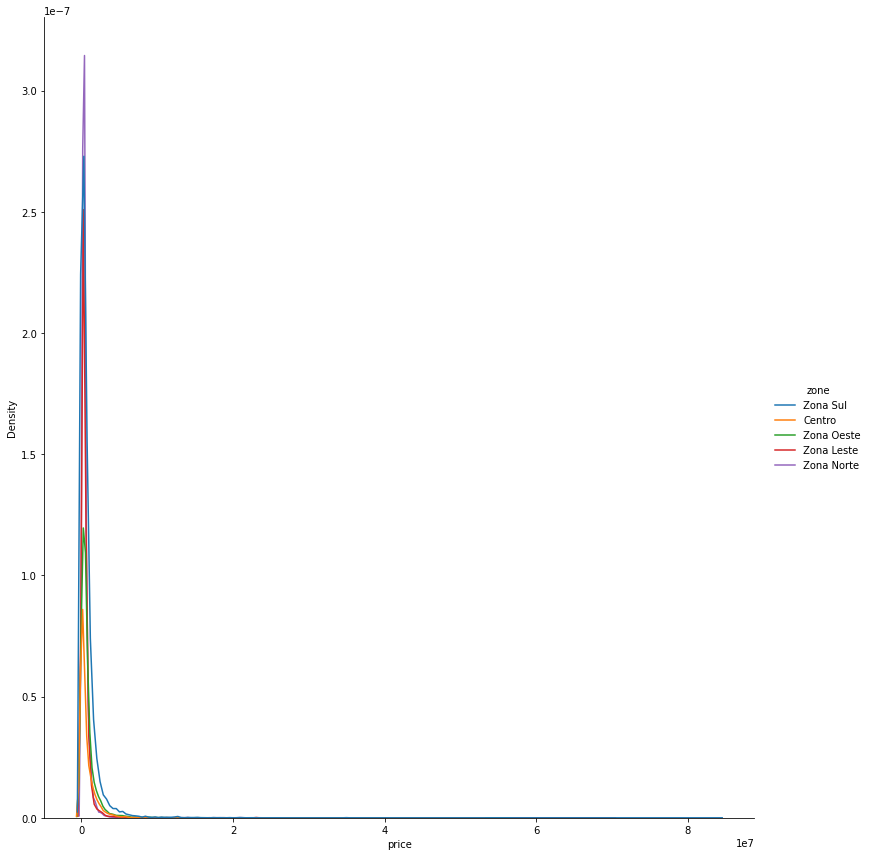

In [11]:
sns.displot(data=train, x="price", hue="zone", kind="kde", height=12, aspect=.90)

In [12]:
train.zone.value_counts()

Zona Sul      48860
Zona Norte    28643
Zona Leste    24228
Zona Oeste    19633
Centro        12600
Name: zone, dtype: int64

In [14]:
#É possível verificar que temos muito mais registros a venda do que aluguel. Logo vamos analisar esses dados por enquanto.
train.sale.value_counts()

1    105332
0     28632
Name: sale, dtype: int64

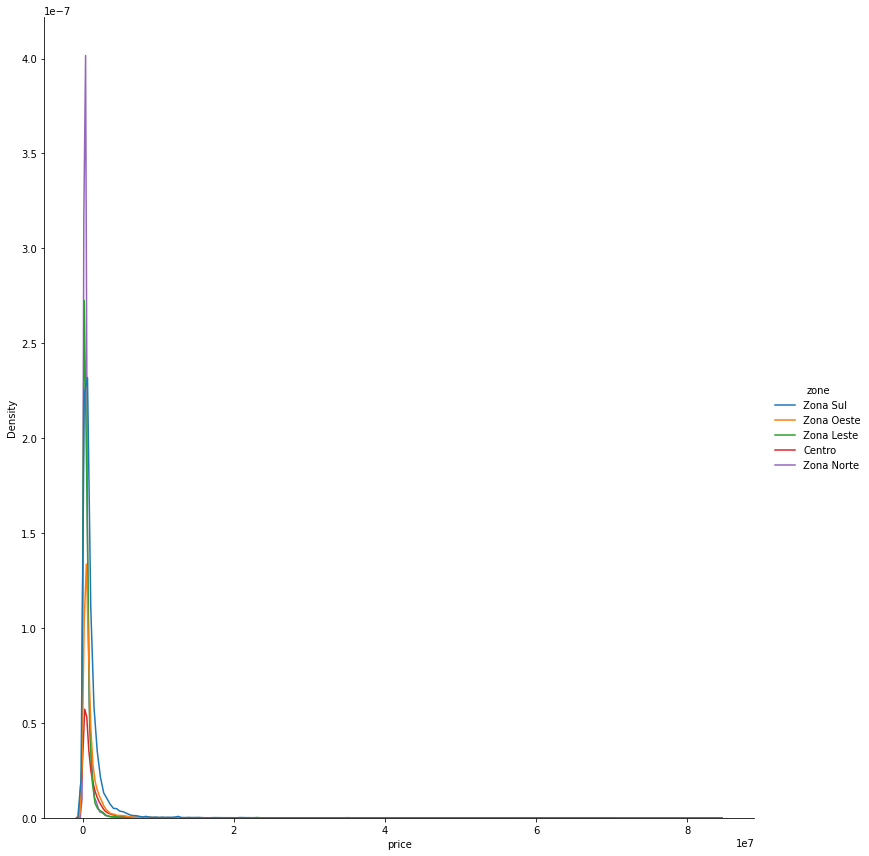

In [15]:
#A distribuição de preços ainda se encontra muito concentrada
sns.displot(data=train[train.sale == 1], x="price", hue="zone", kind="kde", height=12, aspect=.90)

## Como boa parte do meu dataset de treino é referente a anúncios de vendas, irei analisar a parte

In [16]:
s_train = train[train.sale == 1]

In [17]:
s_train.head()

,usableAreas,description,title,unitTypes,listingStatus,parkingSpaces,owner,suites,publicationType,bathrooms,...,sale,period,zipCode,city,zone,street,district,state,neighborhood,price
0,388,"04 dorms sendo 01 suíte e closet, sala de esta...",PRÓXIMO A AVENIDA PRESIDENTE TANCREDO NEVES,TWO_STORY_HOUSE,ACTIVE,6,False,1,STANDARD,3,...,1,VENDA,4290030,São Paulo,Zona Sul,Rua Juvenal Galeno,Jardim da Saude,São Paulo,Jardim da Saúde,700000
1,129,"03 dorms sendo 01 suíte, sala, sala de jantar,...",PRÓXIMO A FACULDADE UNIP CAMPUS ANCHIETA,HOME,ACTIVE,2,False,1,STANDARD,2,...,1,VENDA,4187320,São Paulo,Zona Sul,Rua Juruaba,Vila Liviero,São Paulo,Vila Santa Teresa (Zona Sul),336000
3,80,"Viva melhor e de um jeito novo, com privilégio...","Apartamento com 80m², 2 vagas próximo ao Parqu...",APARTMENT,ACTIVE,2,False,1,STANDARD,2,...,1,VENDA,4550004,São Paulo,Zona Sul,Rua Alvorada,Vila Olimpia,São Paulo,Vila Olímpia,739643
4,3322,Sua área é ocupada majoritariamente por instit...,"Apartamento 332m², 4 suítes à venda próximo ao...",APARTMENT,ACTIVE,5,False,4,STANDARD,5,...,1,VENDA,4005030,São Paulo,Zona Sul,Rua Curitiba,Paraiso,São Paulo,Paraíso,7520099
6,94,"Apartamento em ótimo bairro, bem localizado a ...",APARTAMENTO EM PINHEIROS!!!,APARTMENT,ACTIVE,2,False,0,STANDARD,1,...,1,VENDA,5415040,São Paulo,Zona Oeste,Rua Mateus Grou,Pinheiros,São Paulo,Pinheiros,630700


Analisando algumas métricas agrupadas pela zona, temos algumas informações importantes.

- A variância entre o menor preço e o maior preço é bem grande numa primeira vista<br>
- A mediana se manteve praticamente próxima nas zonas Central, Leste e Norte<br>
- O valor médio é bem maior na Zona Oeste e Zona Sul, já o Centro e Zona Norte tem os menores valores médios

In [18]:
s_train.groupby(['zone']).agg({'price':['mean', 'median', 'min', 'max']})

price                         
                    mean  median    min       max
zone                                             
Centro      1.075154e+06  598500   7000  52500000
Zona Leste  5.727296e+05  371000  10500  70000000
Zona Norte  5.342438e+05  378000  11900  46200000
Zona Oeste  1.012117e+06  595000  41993  56000000
Zona Sul    1.101620e+06  630000  14559  84000000

Separando o dataset somente de vendas e além disso olhando mais a fundo o tipo de imóvel, agora é possível determinar<br>
quais são os tipos de imóveis que puxam o preço para cima.

In [71]:
s_train.groupby(['unitTypes']).agg({'price':['mean', 'median', 'min', 'max']})

price                                
                                    mean        median     min       max
unitTypes                                                               
APARTMENT                    $763,357.45   $465,499.00   10500  74200000
BUSINESS                   $1,197,413.35   $766,220.00   33600   9100000
CLINIC                       $752,551.18   $770,000.00  206224   1610000
COMMERCIAL_ALLOTMENT_LAND  $2,168,650.62   $896,000.00   41993  70000000
COMMERCIAL_BUILDING        $4,700,801.78 $2,516,500.00  476951  23450000
...                                  ...           ...     ...       ...
RESIDENTIAL_ALLOTMENT_LAND $1,315,916.45   $630,000.00   41993  46200000
RESIDENTIAL_BUILDING         $571,234.84   $281,015.00  108430   5249999
SHED_DEPOSIT_WAREHOUSE     $2,796,555.37 $1,400,000.00  171500  41300000
STORE                      $2,136,737.60   $968,784.00   49000  17500000
TWO_STORY_HOUSE              $686,226.25   $481,949.00   98000  21000000

[19 rows x 4 columns]

In [20]:
exemplo = s_train.groupby(['unitTypes']).agg({'price':['mean', 'median', 'min', 'max', 'count']})

Entre os imóveis que possuem os maiores preços também são os que possuem a maior diferença de valores

In [21]:
ex = exemplo.reset_index()
ex.columns=['UnitType','mean','median','min','max','count']
ex.reset_index().sort_values(['max'],ascending=False)

,index,UnitType,mean,median,min,max,count
5,5,COMMERCIAL_PROPERTY,2.109681e+06,910000.0,7000,84000000,1965
0,0,APARTMENT,7.633575e+05,465499.0,10500,74200000,64146
3,3,COMMERCIAL_ALLOTMENT_LAND,2.168651e+06,896000.0,41993,70000000,677
14,14,RESIDENTIAL_ALLOTMENT_LAND,1.315916e+06,630000.0,41993,46200000,1372
12,12,OFFICE,1.059017e+06,455000.0,14559,41993000,2070
...,...,...,...,...,...,...,...
7,7,COUNTRY_HOUSE,1.529062e+06,1067500.0,482999,3860499,8
9,9,FLAT,3.078703e+05,258999.0,101500,3500000,2101
2,2,CLINIC,7.525512e+05,770000.0,206224,1610000,11
8,8,FARM,7.489995e+05,748999.5,237999,1260000,2


In [26]:
ap = s_train[s_train['unitTypes'] == 'COMMERCIAL_PROPERTY']

<Figure size 2520x720 with 0 Axes>

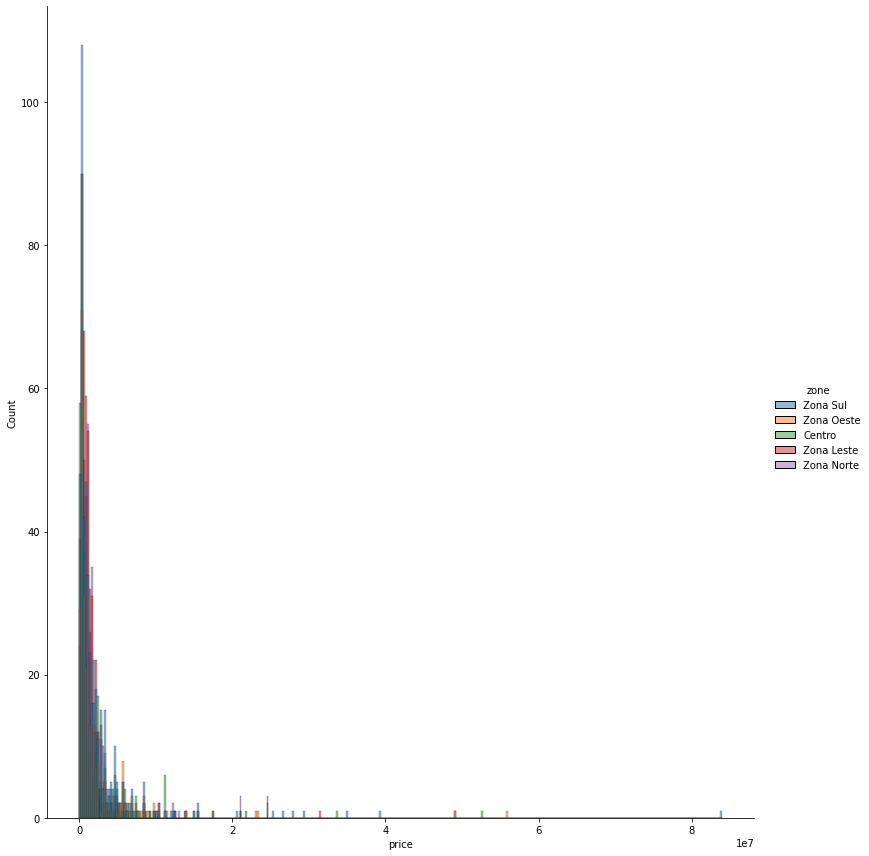

In [29]:
plt.figure(figsize=(35, 10))
sns.displot(data=ap, x="price", hue="zone",  height=12, aspect=.90)

In [20]:
 ap2 = s_train[(s_train['unitTypes'] == 'COMMERCIAL_PROPERTY') & (s_train['price'] < 20000000)]

Como é de se esperar, a maior parte dos anúncios estão abaixo do preço de R$ 20.000.000,00 

<Figure size 2520x720 with 0 Axes>

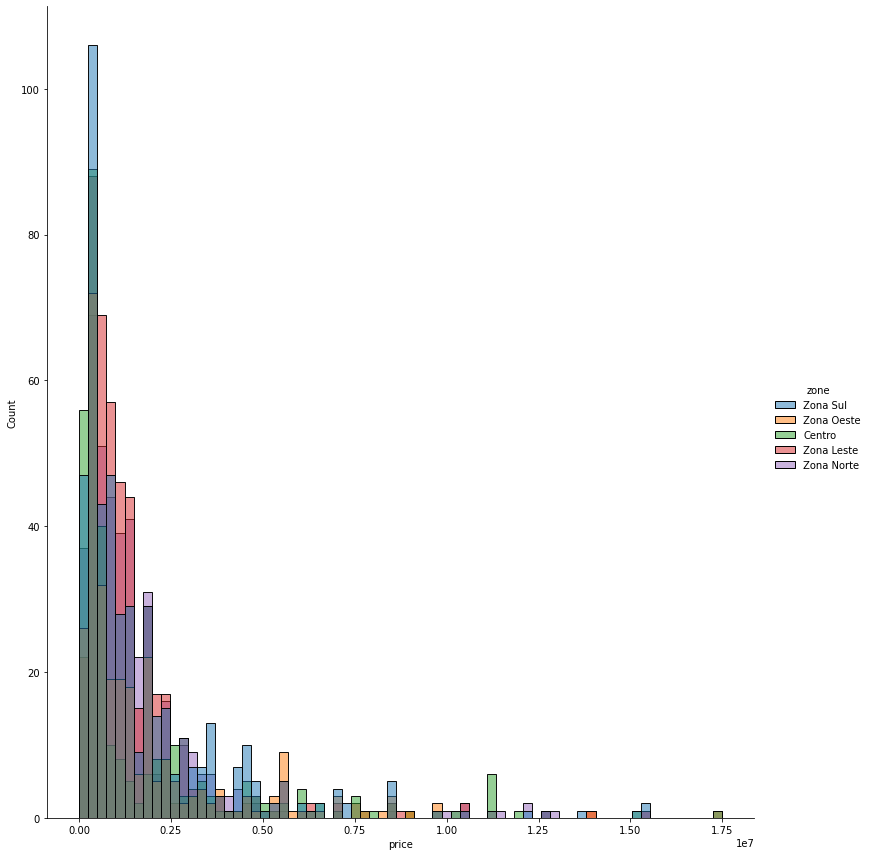

In [21]:
plt.figure(figsize=(35, 10))
sns.displot(data=ap2, x="price", hue="zone",  height=12, aspect=.90)

In [66]:
teste = ap2.sample(1000)

In [50]:
teste.head(1)

,usableAreas,description,title,unitTypes,listingStatus,parkingSpaces,owner,suites,publicationType,bathrooms,totalAreas,bedrooms,sale,period,zipCode,city,zone,street,district,state,neighborhood,price
130934,376,PREDIO COMERCIAL NO BRAS,PREDIO COMERCIAL NO BRAS,COMMERCIAL_PROPERTY,ACTIVE,2,False,1,STANDARD,3,13270,2,1,VENDA,3054040,São Paulo,Zona Leste,Rua Coronel Antônio Marcelo,Bras,São Paulo,Belenzinho,1750000


In [ ]:
apartamentos = s_train[s_train['unitTypes'] == 'APARTMENT']

In [69]:
apartamentos[apartamentos.bedrooms == 2].groupby(['zone']).agg({'price':['mean', 'median', 'min', 'max', 'count']})

price                               
                  mean  median     min      max count
zone                                                 
Centro     $572,173.52  468999  132353  3849999  1579
Zona Leste $253,730.75  234499   10500  4900000  5000
Zona Norte $248,360.22  227500   70000  2100000  5897
Zona Oeste $457,271.99  396480   87500  5040000  3544
Zona Sul   $464,439.52  378910   53690  7000000  8122

Olhando somente o conjunto de apartamentos que representam boa parte do meu conjunto de anúncios de vendas, considerando apenas 2 quartos, a maior média de preço se encontra na região central e o menor na zona Leste.

In [72]:
apartamentos[apartamentos.bedrooms == 1].groupby(['zone']).agg({'price':['mean', 'median', 'min', 'max', 'count']})

price                                
                  mean  median     min       max count
zone                                                  
Centro     $320,128.32  273000   94850   3989999  1633
Zona Leste $287,364.35  214900   73500  25434920   665
Zona Norte $233,245.85  227500   84005    595000   264
Zona Oeste $455,454.54  406000  134964   1750000   691
Zona Sul   $509,844.34  396200  111300  11550000  2218

In [ ]:
Já considerando um quarto, em disparado zona sul possui os maiores preços, talvez pela maior procura de jovens que trabalham
em empresas na zona sul? e com isso maior a procura = maior preço? talvez...

# CREATE MODEL

## RANDOM FOREST SEM TRATAMENTO

In [74]:
#Selecionando apenas númerico e bool
X = treino.select_dtypes(exclude=['object'])

#Splitando meu dataset
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)


model = RandomForestRegressor(n_estimators=100, random_state=1)
#Treinando modelo
model.fit(X_train, y_train)

#Gerando a previsão
preds_valid = model.predict(X_valid)

#Pontuação pelo MAE
print("MAE (Your approach):")
print(mean_absolute_error(y_valid, preds_valid))

MAE (Your approach):
163064.63102408187


## RANDOM FOREST + HOT ENCODING


In [75]:
#Apenas para visualizar a distribuição das maiores concentrações
district_distr = pd.DataFrame(treino.district.value_counts(normalize=True))

#85% da distribuição dos distritos estão 
#sum(district_distr[district_distr.district >= 0.001].district)

#157 distritos concentram 85% do meu dataset
top157 = district_distr[district_distr.district >= 0.001][:157].index

#Atualizado os destritos
treino.district = [i if i in top157 else 'other' for i in treino.district]

#Selecionando as colunas que servirão para o encoding
object_cols = ['unitTypes','publicationType','period','zone','district']

#Selecionando apenas dataset diferente de categorico ou texto
dt_num = treino.select_dtypes(exclude=['object'])

#Selecionando apenas as colunas que servirão para o encode
dt_hotcod = treino[object_cols]

#concatenando dataset com as colunas que irei encodar
tudo = pd.concat([dt_num, dt_hotcod], axis=1)

#Tratando esses poucos registros para zona sul para testes
tudo.loc[tudo['zone'] == 'Sao Paulo', 'zone'] = 'Zona Sul'
tudo.loc[tudo['zone'] == 'Barrios', 'zone'] = 'Zona Sul'

#Gerando um split para treinar e validar a abordagem
X_train, X_valid, y_train, y_valid = train_test_split(tudo, y, train_size=0.8, test_size=0.2, random_state=0)

#Gerando o encoding
OH = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_X_train = pd.DataFrame(OH.fit_transform(X_train[object_cols])) 
OH_X_valid = pd.DataFrame(OH.transform(X_valid[object_cols])) 

#Devolvendo index pois é removido durante o encoding
OH_X_train.index = X_train.index
OH_X_valid.index = X_valid.index

#Dropando as colunas categoricas pois já tenho as colunas encodadas
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

#Concatenando meu dataset
OH_X_train = pd.concat([num_X_train, OH_X_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_X_valid], axis=1)

#Execução do modelo com encoding
model = RandomForestRegressor(n_estimators=10, random_state=0)
model.fit(OH_X_train, y_train)
preds = model.predict(OH_X_valid)

#Pontuação pelo MAE
print("MAE")
print(mean_absolute_error(y_valid, preds))

MAE
152793.25079518344


In [76]:
#Defini a função MAPE para cálculo da porcentagem dos erros
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [77]:
#Porcentagem de erros 24%
print(MAPE(y_valid, preds))

24.686069430851358


## XGBRegressor HOT ENCODING

In [6]:
from xgboost import XGBRegressor

my_model = XGBRegressor(n_estimators=100, verbose=False)
my_model.fit(OH_X_train, y_train, early_stopping_rounds=5, eval_set=[(OH_X_valid, y_valid)], verbose=False)


predictions = my_model.predict(OH_X_valid)
print(mean_absolute_error(y_valid, predictions))

[16:39:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


202428.2894179222


# PREVISÃO COM DATASET TESTE BASEADO NO MODELO TREINADO COM RANDOM FOREST + HOT ENCODING

## Tal modelo foi escolhido pois em testes executados com o modelo Random Forest os resultados sempre foram melhores comparados ao XGBRegressor e Random Forest puro. Com a adição do tratamento Hot Encoding para transformar as variáveis categórias o resultado foi ainda melhor.

In [98]:
teste = teste.astype({"sale": bool})

#Como não existe zona = Sao Paulo irei determinar como Zona Sul por enquanto
teste.loc[teste['zone'] == 'Sao Paulo', 'zone'] = 'Zona Sul'

#Como se trata de poucos registros e como não irei utilizar tais campos irei deixar por enquanto como vazio
teste.loc[teste.description.isnull(), 'description'] = 'vazio'
teste.loc[teste.title.isnull(), 'title'] = 'vazio'

#Selecionando apenas dataset diferente de categorico ou texto
dt_num_teste = teste.select_dtypes(exclude=['object'])

#Selecionando apenas as colunas que servirão para o encode
dt_hotcod_teste = teste[object_cols]

#concatenando dataset com as colunas que irei encodar
tudo_teste = pd.concat([dt_num_teste, dt_hotcod_teste], axis=1)

OH_X_teste = pd.DataFrame(OH.transform(tudo_teste[object_cols])) 
OH_X_teste.index = tudo_teste.index
num_X_teste = tudo_teste.drop(object_cols, axis=1)
OH_X_valid_test = pd.concat([num_X_teste, OH_X_teste], axis=1)

#Prevendo com base no modelo treinado
preds_test = model.predict(OH_X_valid_test)

#Arredondando valor previsto
preds_round = [round(x,2) for x in preds_test]

#Salvando o resultado
output = pd.DataFrame({'Id':OH_X_teste.index,'Price':preds_round})
output.to_csv('prediction_results.csv', index=False)